https://www.kaggle.com/cdeotte/200-magical-models-santander-0-920

In [1]:
# LOAD LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, numpy as np, gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import statsmodels.api as sm

In [2]:
# GET INDICIES OF REAL TEST DATA FOR FE
#######################
# TAKE FROM YAG320'S KERNEL
# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

test_path = './input/test.csv'

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

# 找只出现一次的特征值并记录 unique_samples 显示为 1 ，其余显示为 0
unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# _, index_, count_ = np.unique([1, 2, 3, 3, 4, 4, 4], return_counts=True, return_index=True)
# 
# >>> _
# array([1, 2, 3, 4])
# >>> index_
# array([0, 1, 2, 4], dtype=int64)
# >>> count_
# array([1, 1, 2, 3], dtype=int64)
# >>> index_[count_ == 1]
# array([0, 1], dtype=int64)

print('unique_count shape : ', unique_count.shape)

print('np.sum(unique_count, axis=1) shape : ', np.shape(np.sum(unique_count, axis=1)))
# 按行相加
    
# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]  # 下标
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

unique_count shape :  (200000, 200)
np.sum(unique_count, axis=1) shape :  (200000,)
Found 100000 real test
Found 100000 fake test


## 加载数据

In [3]:
d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv('./input/train.csv', dtype=d)
test = pd.read_csv('./input/test.csv', dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')

Loaded 200000 rows of train
Loaded 200000 rows of test


In [47]:
train_df = pd.DataFrame(train[['var_0', 'target']])
train_df.head()

,var_0,target
0,8.9255,0
1,11.5006,0
2,8.6093,0
3,11.0604,0
4,9.8369,0


In [48]:
cotmp = train_df['var_0'].value_counts()
type(cotmp)

pandas.core.series.Series

In [49]:
train_df['var_0_size'] = train_df['var_0'].map(cotmp)
train_df.head()

,var_0,target,var_0_size
0,8.9255,0,6
1,11.5006,0,2
2,8.6093,0,4
3,11.0604,0,3
4,9.8369,0,3


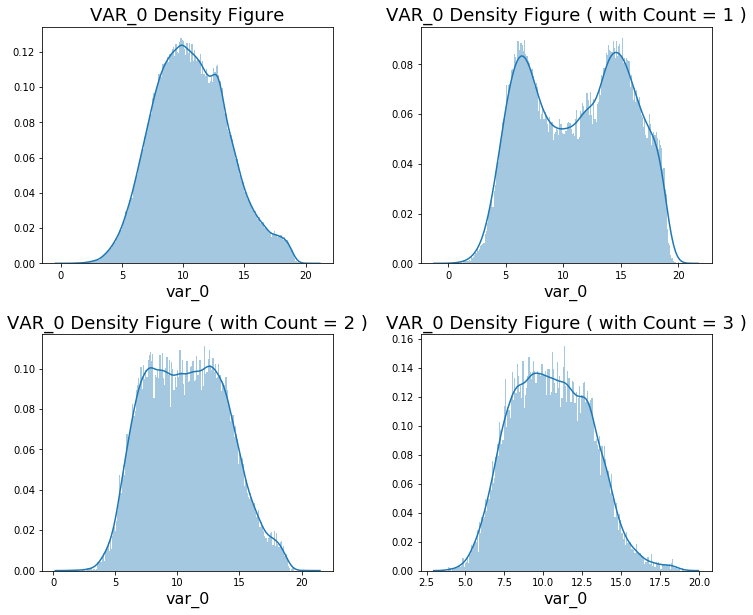

In [53]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

plt.subplot(2,2,1)

plt.title('VAR_0 Density Figure', fontsize=18)
plt.xlabel('Var_0', fontsize=16)
sns.distplot(train_df['var_0'], bins=200)

plt.subplot(2,2,2)

plt.title('VAR_0 Density Figure ( with Count = 1 )', fontsize=18)
plt.xlabel('Var_0 (Count = 1)', fontsize=16)
sns.distplot(train_df[train_df['var_0_size']==1]['var_0'], bins=200)

plt.subplot(2,2,3)

plt.title('VAR_0 Density Figure ( with Count = 2 )', fontsize=18)
plt.xlabel('Var_0 (Count = 1)', fontsize=16)
sns.distplot(train_df[train_df['var_0_size']==2]['var_0'], bins=200)

plt.subplot(2,2,4)

plt.title('VAR_0 Density Figure ( with Count = 3 )', fontsize=18)
plt.xlabel('Var_0 (Count = 1)', fontsize=16)
sns.distplot(train_df[train_df['var_0_size']==3]['var_0'], bins=200)

plt.show()

In [37]:
# FREQUENCY ENCODE
def encode_FE(df, col, test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)  # 用频数替代数值 —— 新特征
    test[nm] = test[col].map(cv)  # 用频数替代数值 —— 新特征
    test[nm].fillna(0, inplace=True)  # 用 0 填充缺失值，缺失的部分是 Fake Data
    if cv.max() <= 255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

In [38]:
test['target'] = -1
comb = pd.concat([train, test.loc[real_samples_indexes]], axis=0,sort=True)  # 拼接训练集和测试集
for i in range(200):
    encode_FE(comb, 'var_'+str(i), test)
train = comb[:len(train)]
del comb
print('Added 200 new magic features!')

Added 200 new magic features!


In [39]:
print(np.shape(train))
print(np.shape(test))

(200000, 402)
(200000, 402)


In [40]:
# LGBM PARAMETERS
param = {
    'learning_rate': 0.04,
    'num_leaves': 3,
    'metric':'auc',
    'boost_from_average':'false',
    'feature_fraction': 1.0,
    'max_depth': -1,
    'objective': 'binary',
    'verbosity': -10
}

VAR_0 with magic val_auc = 0.54785


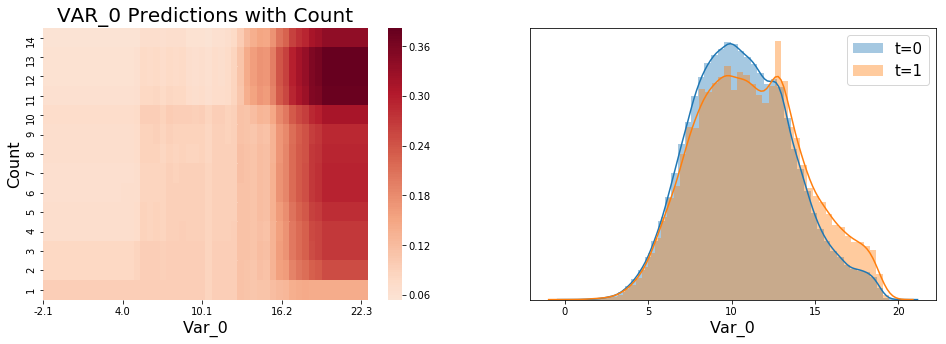

VAR_0 without magic val_auc = 0.53248


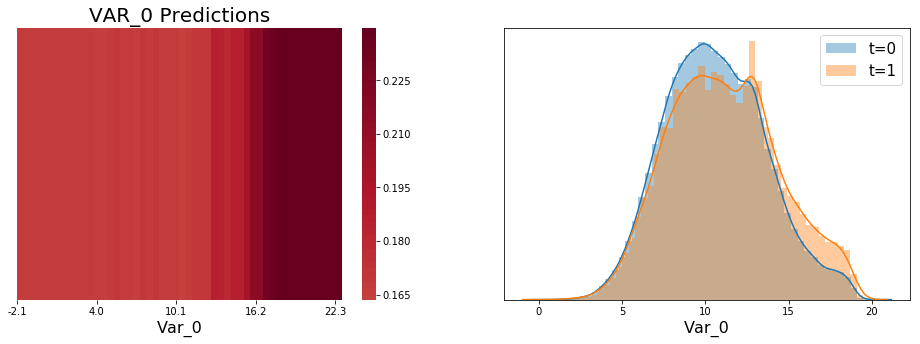

In [41]:
train2 = train.sample(frac=1, random_state=42)  # 乱序所有样本
evals_result = {}
num_vars = 1

# SAVE OUT-OF-FOLD PREDICTIONS 折外预测
all_oof = np.zeros((len(train2),num_vars+1))
all_oof[:,0] = np.ones(len(train2))
all_oofB = np.zeros((len(train2),num_vars+1))
all_oofB[:,0] = np.ones(len(train2))

# SAVE TEST PREDICTIONS
all_preds = np.zeros((len(test),num_vars+1))
all_preds[:,0] = np.ones(len(test))
all_predsB = np.zeros((len(test),num_vars+1))
all_predsB[:,0] = np.ones(len(test))


for j in range(num_vars):
    
    # MODEL WITH MAGIC  特征 和 magic 特征
    features = ['var_'+str(j), 'var_'+str(j)+'_FE']
    oof = np.zeros(len(train2))
    preds = np.zeros(len(test))
    
    # PLOT DENSITIES  训练集中两类样本 原始特征 的密度图
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,2)
    sns.distplot(train2[train2['target']==0]['var_'+str(j)], label = 't=0')
    sns.distplot(train2[train2['target']==1]['var_'+str(j)], label = 't=1')
    plt.legend(prop = {'size':15})
    plt.yticks([])
    plt.xlabel('Var_'+str(j), fontsize=16)

    # MAKE A GRID OF POINTS FOR LGBM TO PREDICT    
    mn, mx = plt.xlim()  # 横坐标参数范围
    mnFE = train2['var_'+str(j)+'_FE'].min()
    mxFE = train2['var_'+str(j)+'_FE'].max()
    step = 50
    stepB = train2['var_'+str(j)+'_FE'].nunique()  # 不同的数字有几个
    w = (mx - mn) / step  # 范围除以step ， w 是间隔 ？
    x = w * (np.arange(0,step) + 0.5) + mn  # x 是坐标点 ？
    x2 = np.array([])
    for i in range(stepB):
        x2 = np.concatenate([x, x2])  # x 重复 stepB 次，赋值给 x2
    df = pd.DataFrame({'var_'+str(j):x2})
    df['var_'+str(j)+'_FE'] = mnFE + (mxFE - mnFE) / (stepB - 1) * (df.index//step)
    df['pred'] = 0
    
    # 5-FOLD WITH MAGIC
    for k in range(5):
        valid = train2.iloc[k * 40000 : (k+1) * 40000]
        train = train2[ ~train2.index.isin(valid.index) ]
        # 设置 lgb 数据集
        trn_data  = lgb.Dataset(train[features], label=train['target'])
        val_data = lgb.Dataset(valid[features], label=valid['target'])     
        model = lgb.train(param, trn_data, 750, 
                          valid_sets = [trn_data, val_data], 
                          verbose_eval=False, evals_result=evals_result)      
        x = evals_result['valid_1']['auc']
        best = x.index(max(x))
        #print('i=',i,'k=',k,'best=',best)
        oof[k*40000:(k+1)*40000] = model.predict(valid[features], num_iteration=best)
        preds += model.predict(test[features], num_iteration=best)/5.0
        df['pred'] += model.predict(df[features], num_iteration=best)/5.0
            
    val_auc = roc_auc_score(train2['target'], oof)
    print('VAR_'+str(j)+' with magic val_auc =', round(val_auc,5))
    all_oof[:,j+1] = oof
    all_preds[:,j+1] = preds
    x = df['pred'].values
    x = np.reshape(x,(stepB,step))
    x = np.flip(x,axis=0)
    
    # PLOT LGBM PREDICTIONS USING MAGIC  用 magic 特征
    plt.subplot(1,2,1)
    sns.heatmap(x, cmap='RdBu_r', center=0.0) 
    plt.title('VAR_'+str(j)+' Predictions with Count', fontsize=20)    
    plt.xticks(np.linspace(0, 49, 5), np.round(np.linspace(mn, mx, 5), 1))
    plt.xlabel('Var_'+str(j), fontsize=16)
    s = min(mxFE-mnFE+1,20)
    plt.yticks(np.linspace(mnFE,mxFE,s)-0.5,np.linspace(mxFE,mnFE,s).astype('int'))
    plt.ylabel('Count', fontsize=16)
    plt.show()
    
    # MODEL WITHOUT MAGIC
    features = ['var_'+str(j)]
    oof = np.zeros(len(train2))
    preds = np.zeros(len(test))
    
    # PLOT DENSITIES
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,2)
    sns.distplot(train2[train2['target']==0]['var_'+str(j)], label = 't=0')
    sns.distplot(train2[train2['target']==1]['var_'+str(j)], label = 't=1')
    plt.legend(prop = {'size':15})
    plt.yticks([])
    plt.xlabel('Var_'+str(j), fontsize=16)
    
    # MAKE A GRID OF POINTS FOR LGBM TO PREDICT
    mn,mx = plt.xlim()
    mnFE = train2['var_'+str(j)+'_FE'].min()
    mxFE = train2['var_'+str(j)+'_FE'].max()
    step = 50
    stepB = train2['var_'+str(j)+'_FE'].nunique()
    w = (mx-mn)/step
    x = w * (np.arange(0,step)+0.5) + mn
    x2 = np.array([])
    for i in range(stepB):
        x2 = np.concatenate([x,x2])
    df = pd.DataFrame({'var_'+str(j):x2})
    df['var_'+str(j)+'_FE'] = mnFE + (mxFE-mnFE)/(stepB-1) * (df.index//step)
    df['pred'] = 0
    
    # 5-FOLD WITHOUT MAGIC
    for k in range(5):
        valid = train2.iloc[k*40000:(k+1)*40000]
        train = train2[ ~train2.index.isin(valid.index) ]
        trn_data  = lgb.Dataset(train[features], label=train['target'])
        val_data = lgb.Dataset(valid[features], label=valid['target'])     
        model = lgb.train(param, trn_data, 750, valid_sets = [trn_data, val_data], 
                verbose_eval=False, evals_result=evals_result)      
        x = evals_result['valid_1']['auc']
        best = x.index(max(x))
        #print('i=',i,'k=',k,'best=',best)
        oof[k*40000:(k+1)*40000] = model.predict(valid[features], num_iteration=best)
        preds += model.predict(test[features], num_iteration=best)/5.0
        df['pred'] += model.predict(df[features], num_iteration=best)/5.0
            
    val_auc = roc_auc_score(train2['target'],oof)
    print('VAR_'+str(j)+' without magic val_auc =', round(val_auc,5))
    all_oofB[:,j+1] = oof
    all_predsB[:,j+1] = preds
    x = df['pred'].values
    x = np.reshape(x,(stepB,step))
    x = np.flip(x,axis=0)
    
    # PLOT LGBM PREDICTIONS WITHOUT USING MAGIC
    plt.subplot(1,2,1)
    sns.heatmap(x, cmap='RdBu_r', center=0.0) 
    plt.title('VAR_'+str(j)+' Predictions', fontsize=20)
    plt.xticks(np.linspace(0, 49, 5), np.round(np.linspace(mn, mx, 5), 1))
    plt.xlabel('Var_'+str(j), fontsize=16)
    plt.yticks([])
    plt.ylabel('')
    plt.show()

In [20]:
# ENSEMBLE MODEL WITHOUT MAGIC
logrB = sm.Logit(train2['target'], all_oofB[:,:num_vars+1])
logrB = logrB.fit(disp=0)
ensemble_predsB = logrB.predict(all_oofB[:,:num_vars+1])
ensemble_aucB = roc_auc_score(train2['target'],ensemble_predsB)  
print('##################')
print('Combined Model without magic Val_AUC=',round(ensemble_aucB,5))
print()

# ENSEMBLE MODEL WITH MAGIC
logr = sm.Logit(train2['target'], all_oof[:,:num_vars+1])
logr = logr.fit(disp=0)
ensemble_preds = logr.predict(all_oof[:,:num_vars+1])
ensemble_auc = roc_auc_score(train2['target'],ensemble_preds)  
print('##################')
print('Combined Model with magic Val_AUC=',round(ensemble_auc,5))
print()

##################
Combined Model without magic Val_AUC= 0.89698

##################
Combined Model with magic Val_AUC= 0.92011



Test predictions saved as submission.csv
OOF predictions saved as oof_submission.csv
Histogram of test predictions displayed below:


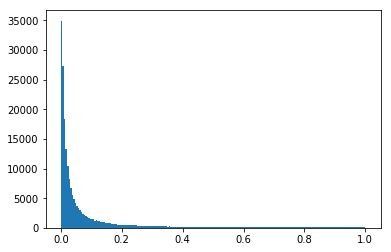

In [21]:
# SAVE PREDICTIONS TO CSV    
print('Test predictions saved as submission.csv')
print('OOF predictions saved as oof_submission.csv')
print('Histogram of test predictions displayed below:')

sub = train2[['ID_code','target']].copy()
sub['predict'] = ensemble_preds
sub.reset_index(inplace=True)
sub.sort_values('index',inplace=True)
sub.to_csv('Magic_oof_submission.csv',index=False)

test_preds = logr.predict(all_preds[:,:num_vars+1])
sub = pd.read_csv('./input/sample_submission.csv')
sub['target'] = test_preds
sub.to_csv('Magic_submission.csv',index=False)

# DISPLAY HISTOGRAM OF PREDICTIONS
b = plt.hist(sub['target'], bins=200)